# Sample Algo Strategies Report

In [1]:
# Standard library
import pandas as pd

# Backtesting library
import backtrader as bt 
import backtrader.indicators as btind
from IPython.display import Image

## 1. Define indicators

**MACD**: The standard MACD(12, 26, 9) with period 12 for the fast EMA, period 26 for the slow EMA and period 9 for the signal-line. Both, the signals from the crossovers of the MACD with the signal-line and the signals from the MACD crossovers with the zero-line were backtested.

**Moving Average Crossover**: Periods 50 and 26 were tested for the slow moving average, respectively periods 20 and 12 for the fast moving average. The parameter combination (26, 12) was chosen, since the EMA-Crossover with these parameters has been backtested as well by demanding a crossover of the MACD with the zero-line.


**Price Channel Break**: Highest High (HH) and Lowest Low (LL) price channel with both having period 20 was used.

**Bollinger Bands**: Standard parameters, 20 for the moving average and 2 for the number of standard deviations (std), were used for the Bollinger Band strategy BB(per=20, std=2). For long-only signals both, the cross-up and cross-down of the candle-close with the upper band were used as entry-signals. The closing signal was triggered by a cross-down of a candle-close with the lower band. The short-only signals would be given exactly by the inverse.

### Trigger conditions

Bollinger Band Width condition (**BBW_condition**): The BBW condition is satisfied if the fast SMA (period 10) of the BBW is larger than the a slow SMA (period 50) of the BBW.

$$
\text{BBW condition} = \text{SMA}(\text{BBW}, \text{per}=10) > \text{SMA}(\text{BBW}, \text{per}=50)
$$

Volume condition (**vol_condition**:) The vol condition is met when the fast SMA (period 10) of the hourly volume is larger than the slow SMA (period 50) of the hourly volume.

$$
\text{vol condition} = \text{SMA}(\text{volume}, \text{per}=10) > \text{SMA}(\text{volume}, \text{per}=50)
$$

## 2. Sample Strategy

Define parameters:
- Asset class: BTC
- Exchange: Binance
- Time period: Jan, 1st 2020 - Jan, 1st 2024
- Timeframe: 1h tick

### MACD+BBW

Logic:

```bash
if MACD > 0 and BBW cond:
    long
if MACD < 0 and BBW cond: 
    close
```

In [ ]:
class MACD_BBW(bt.Strategy):
    params = (
        ('BBW_short', 10),
        ('BBW_long', 50),
        ('volume_short', 10),
        ('volume_long', 50),
        ('printlog', False),
    )

    def __init__(self):
        self.dataclose = self.datas[0].close
        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Define indicators
        self.bb = btind.BollingerBands(self.dataclose, period = 0, devfactor = 2)
        self.bbw = (self.bb.lines.top - self.bb.lines.bot) / self.bb.lines.mid
        self.bbw_short = btind.MovingAverageSimple(self.bbw, period = self.params.BBW_short)
        self.bbw_long = btind.MovingAverageSimple(self.bbw, period = self.params.BBW_long)
        self.macd = btind.MACD(self.dataclose, period_me1=12, period_me2=26, period_signal=9)

    def log(self, txt, dt=None, doprint=False):
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None            

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check for open orders
        if self.order:
            return

        # Check if we are in the market
        if not self.position:
            # We are not in the market, look for a signal to OPEN trades
            if self.macd.macd[0] > 0 and self.bbw_short[0] > self.bbw_long[0]:
                self.log(f'BUY CREATE {self.dataclose[0]:2f}')
                self.order = self.buy(size=1)
        else:
            # We are in the market, look for a signal to CLOSE trades
            if self.macd.macd[0] < 0 and self.bbw_short[0] > self.bbw_long[0]:
                self.log(f'SELL CREATE {self.dataclose[0]:2f}')
                self.order = self.sell(size=1)

Backtesting result:

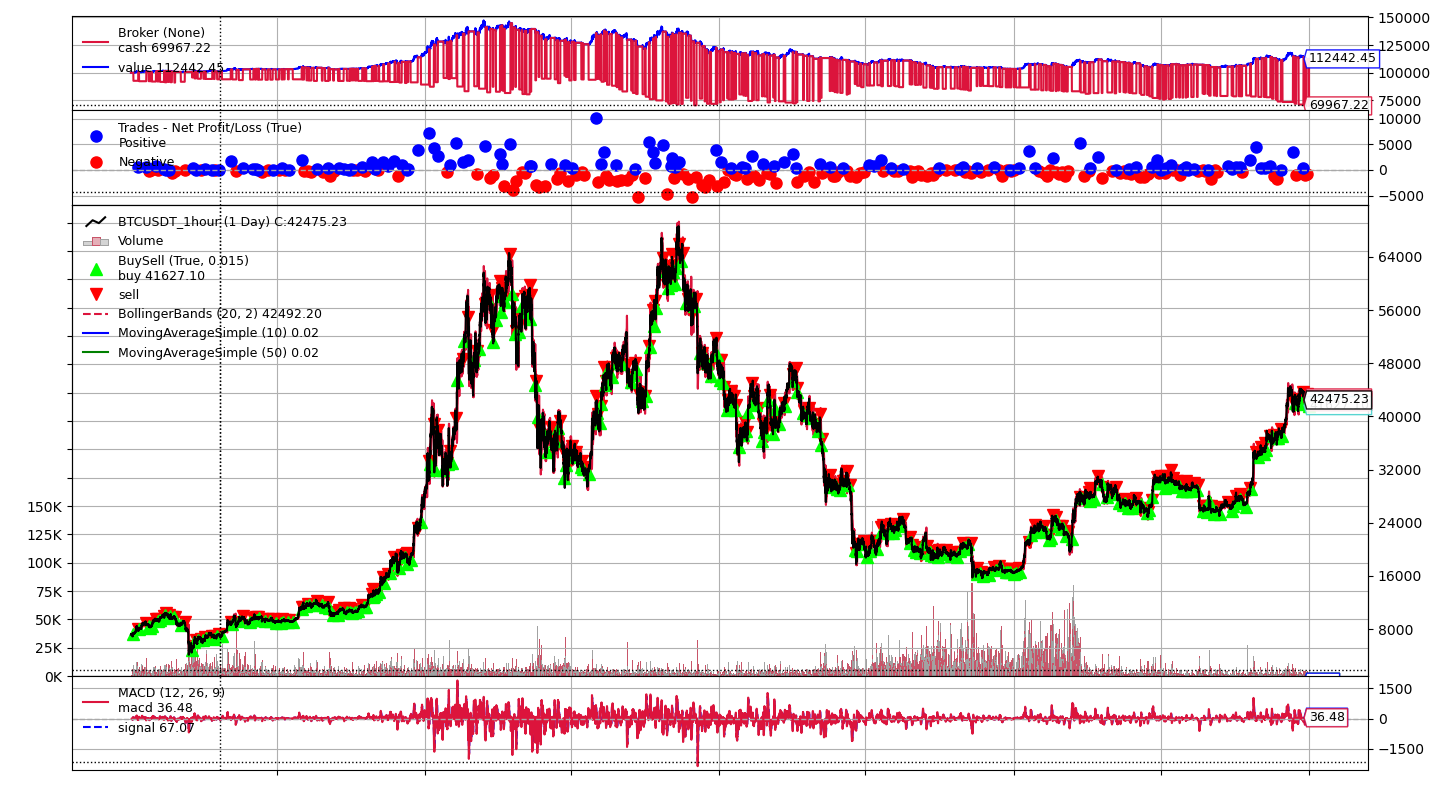

In [2]:
Image("/Users/baobach/Algo-Trading-Binance/research/img/testsample.png")

- Maximum drawdown: 29.82%
- Sharpe: 0.1830
- Returns: 2.04193
- Initial: $100,000
- Final: $112,442.45

---

## Reference

1. https://ethz.ch/content/dam/ethz/special-interest/mtec/chair-of-entrepreneurial-risks-dam/documents/dissertation/master%20thesis/Master_Thesis_Glücksmann_13June2019.pdf